Trabajo Final ML Juan Pablo Chacón, Valentina Miguez, Daniel Bolívar, Ítalo Daza

In [166]:
!pip install flask
!pip install nltk
!pip install urllib3
!pip install bs4
!pip install textblob

You should consider upgrading via the 'c:\users\acer\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\acer\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\acer\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\acer\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\acer\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [167]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
# NLTK VADER for sentiment analysis
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
# for extracting data from finviz
finviz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [168]:
def get_news(ticker):
    url = finviz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    return news_table

In [169]:
# parse news into dataframe
def parse_news(news_table):
    parsed_news = []
    
    for x in news_table.findAll('tr'):
        text = x.a.get_text()  
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        parsed_news.append([date, time, text])        
        columns = ['date', 'time', 'headline']
        parsed_news_df = pd.DataFrame(parsed_news, columns=columns)        
        parsed_news_df['datetime'] = pd.to_datetime(parsed_news_df['date'] + ' ' + parsed_news_df['time'])
        
    return parsed_news_df

In [170]:
def score_news(parsed_news_df):
    # Instantiate the sentiment intensity analyzer
    vader = SentimentIntensityAnalyzer()
    
    # Iterate through the headlines and get the polarity scores using vader
    scores = parsed_news_df['headline'].apply(vader.polarity_scores).tolist()

    # Convert the 'scores' list of dicts into a DataFrame
    scores_df = pd.DataFrame(scores)

    # Join the DataFrames of the news and the list of dicts
    parsed_and_scored_news = parsed_news_df.join(scores_df, rsuffix='_right')        
    parsed_and_scored_news = parsed_and_scored_news.set_index('datetime')    
    parsed_and_scored_news = parsed_and_scored_news.drop(['date', 'time'], 1)          
    parsed_and_scored_news = parsed_and_scored_news.rename(columns={"compound": "sentiment_score"})

    return parsed_and_scored_news

In [171]:
def plot_hourly_sentiment(parsed_and_scored_news, ticker):
   
    # Group by date and ticker columns from scored_news and calculate the mean
    mean_scores = parsed_and_scored_news.resample('H').mean()

    # Plot a bar chart with plotly 
    fig = px.bar(mean_scores, x=mean_scores.index, y='sentiment_score', title = ticker + ' Hourly Sentiment Scores')
    fig.show()

In [172]:
def plot_daily_sentiment(parsed_and_scored_news, ticker):
   
    # Group by date and ticker columns from scored_news and calculate the mean
    mean_scores = parsed_and_scored_news.resample('D').mean()

    # Plot a bar chart with plotly
    fig = px.bar(mean_scores, x=mean_scores.index, y='sentiment_score', title = ticker + ' Daily Sentiment Scores')
    fig.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_15384\2727784192.py:14: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



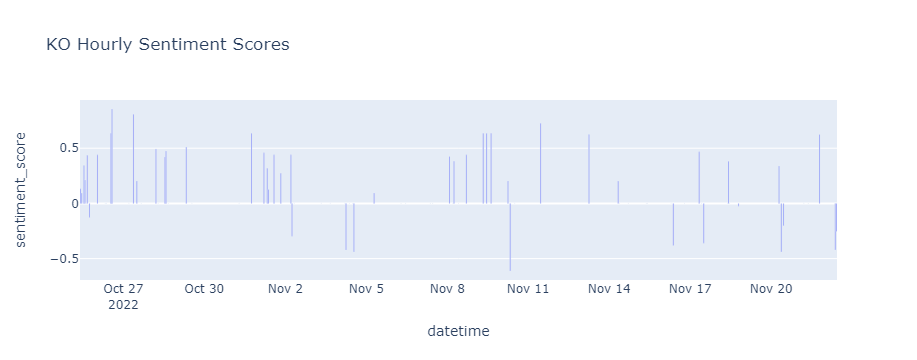

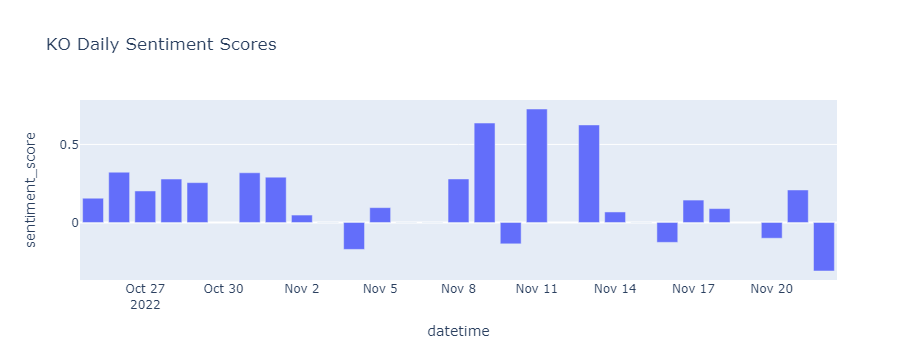

,headline,neg,neu,pos,sentiment_score
datetime,,,,,
2022-11-22 10:31:00,10 Coca-Cola Products You Cant Buy Anymore,0.000,1.000,0.000,0.0000
2022-11-22 10:30:00,2 Soaring Stocks I'd Buy Now With No Hesitation,0.417,0.583,0.000,-0.5106
2022-11-22 09:30:00,Coca-Cola (KO) Recently Broke Out Above the 20...,0.237,0.763,0.000,-0.4215
2022-11-21 19:27:00,Is it a Good Move to Keep Your Coca-Cola (KO) ...,0.000,0.611,0.389,0.6249
2022-11-21 09:15:00,5 Dividend Stocks to Build Your Portfolio Arou...,0.000,1.000,0.000,0.0000


In [204]:
ticker = "KO"
news_table = get_news(ticker)
parsed_news_df = parse_news(news_table)
parsed_and_scored_news = score_news(parsed_news_df)
plot_hourly_sentiment(parsed_and_scored_news, ticker)
plot_daily_sentiment(parsed_and_scored_news, ticker)
parsed_and_scored_news.head()

In [205]:
import yfinance as yf
import numpy as np
fechai = "2022-11-16"
fechaf = "2022-11-22"
price = yf.download(ticker,start=fechai,end=fechaf, interval = "1h")['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [206]:
retornos = np.log(price) - np.log(price.shift(1))
retornos.dropna(inplace=True)

In [207]:
mean_scores = parsed_and_scored_news.resample('H').mean()
mean_scores.dropna(inplace=True)

In [208]:
#mean_scores.index = pd.to_datetime(mean_scores.index)
#mean_scores.index = mean_scores.index.tz_localize(None)
#retornos.index = pd.to_datetime(retornos.index)
#retornos.index = retornos.index.tz_localize(None)
retornos = pd.DataFrame(retornos)
mean_scores = pd.DataFrame(mean_scores)
retornos.set_index(retornos.index.strftime('%Y-%m-%d %H'),inplace=True)
mean_scores.set_index(mean_scores.index.strftime('%Y-%m-%d %H'),inplace=True)

In [209]:
df = pd.merge(retornos,mean_scores, left_index = True, right_index=True)
df.head(5)

,Adj Close,neg,neu,pos,sentiment_score
2022-11-17 10,-0.001574,0.000,1.000,0.000,0.0000
2022-11-17 12,0.000000,0.238,0.762,0.000,-0.3612
2022-11-18 09,0.007056,0.000,1.000,0.000,0.0000
2022-11-18 10,0.001645,0.090,0.674,0.236,0.3818
2022-11-18 11,-0.003118,0.000,1.000,0.000,0.0000


In [210]:
var = []
for i in range(len(df)):
    if df["sentiment_score"][i] > 0 and df["Adj Close"][i] > 0: #
        var.append(1)
    elif df["sentiment_score"][i] < 0 and df["Adj Close"][i] < 0:
        var.append(1)
    elif df["sentiment_score"][i] == 0:
        var.append(0)
    else:
        var.append(-1)
df["Accuracy"] = var
df

,Adj Close,neg,neu,pos,sentiment_score,Accuracy
2022-11-17 10,-0.001574,0.000,1.000,0.000,0.0000,0
2022-11-17 12,0.000000,0.238,0.762,0.000,-0.3612,-1
2022-11-18 09,0.007056,0.000,1.000,0.000,0.0000,0
2022-11-18 10,0.001645,0.090,0.674,0.236,0.3818,1
2022-11-18 11,-0.003118,0.000,1.000,0.000,0.0000,0
2022-11-21 09,0.010085,0.000,1.000,0.000,0.0000,0


import matplotlib.pyplot as plt
df["Accuracy"].value_counts().plot(kind="bar",xlabel=["1=Acierto","-1=Error","0=No pudo predecir"], title=ticker);